## P8
Małgorzata Kurcjusz-Gzowska 

### ZTM GTFS parser and stop network visualizer

How to use:
1. Download GTFS data from ZTM Warsaw (timetable data):
   https://www.ztm.waw.pl/pliki-do-pobrania/dane-rozkladowe/
2. Extract the archive so the following GTFS files exist inside the `gtfs` folder (next to this script):
   - stops.txt
   - routes.txt
   - trips.txt
   - stop_times.txt
3. Run:
   python P8_parser_Kurcjusz.ipynb
   
This script:
- Loads GTFS data from ZTM Warsaw
- Builds stop-to-stop graphs based on transport type
- Plots the stop network geographically (lat lon)
"""

In [1]:
from pathlib import Path

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Mapping GTFS route_type values to human-readable names
route_type_names = {
    0: "Tram / Light Rail",
    1: "Metro",
    2: "Rail",
    3: "Bus",
}

In [3]:
def load_gtfs(gtfs_dir: Path):
    """
    Load basic GTFS files from the provided directory.

    Returns:
        DataFrames: stops, routes, trips, stop_times
    """
    stops = pd.read_csv(gtfs_dir / "stops.txt", encoding="utf-8-sig")
    routes = pd.read_csv(gtfs_dir / "routes.txt", encoding="utf-8-sig")
    trips = pd.read_csv(gtfs_dir / "trips.txt", encoding="utf-8-sig")
    stop_times = pd.read_csv(gtfs_dir / "stop_times.txt", encoding="utf-8-sig")
    return stops, routes, trips, stop_times


def build_graph_for_route_type(
    route_type_code: int,
    stops: pd.DataFrame,
    routes: pd.DataFrame,
    trips: pd.DataFrame,
    stop_times: pd.DataFrame,
) -> nx.Graph | None:
    """
    Build a stop-to-stop graph for a given GTFS route_type.

    Nodes:
        Stops (stop_id) used in trips belonging to the selected route type.

    Edges:
        Consecutive stops in the same trip (stop_sequence order).

    Returns:
        networkx.Graph or None if no valid data for this route_type
    """

    routes_t = routes[routes["route_type"] == route_type_code]
    if routes_t.empty:
        print(f"[INFO] No routes found for route_type = {route_type_code}")
        return None

    trips_t = trips[trips["route_id"].isin(routes_t["route_id"])]
    if trips_t.empty:
        print(f"[INFO] No trips found for route_type = {route_type_code}")
        return None

    st_t = stop_times[stop_times["trip_id"].isin(trips_t["trip_id"])].copy()
    if st_t.empty:
        print(f"[INFO] No stop_times found for route_type = {route_type_code}")
        return None

    st_t.sort_values(["trip_id", "stop_sequence"], inplace=True)

    edges: set[tuple[str, str]] = set()
    for trip_id, group in st_t.groupby("trip_id"):
        seq = group["stop_id"].tolist()
        for u, v in zip(seq[:-1], seq[1:]):
            if u != v:
                edges.add((u, v))

    if not edges:
        print(f"[INFO] No edges found for route_type = {route_type_code}")
        return None

    used_stop_ids = set(s for edge in edges for s in edge)
    stops_used = stops[stops["stop_id"].isin(used_stop_ids)]

    G = nx.Graph()
    for _, row in stops_used.iterrows():
        G.add_node(
            row["stop_id"],
            name=row.get("stop_name", ""),
            pos=(row.get("stop_lon"), row.get("stop_lat")),
        )

    G.add_edges_from(edges)
    return G

def plot_graph(G: nx.Graph, title: str):
    """
    Plot the graph using lon-lat coordinates.
    """
    pos = nx.get_node_attributes(G, "pos")

    plt.figure(figsize=(8, 8))
    nx.draw(
        G,
        pos,
        node_size=5,
        linewidths=0,
        edge_color="lightgray",
        with_labels=False,
    )
    plt.title(title)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


def main():
    gtfs_dir = Path("gtfs")

    if not gtfs_dir.exists():
        raise FileNotFoundError(
            f"GTFS directory not found: {gtfs_dir}. "
            "Make sure GTFS text files are extracted to 'gtfs' folder."
        )

    stops, routes, trips, stop_times = load_gtfs(gtfs_dir)

    # transport types to visualize
    route_types_to_plot = [0, 1, 2, 3]

    for rt in route_types_to_plot:
        print(f"[INFO] Building graph for route_type = {rt} ({route_type_names.get(rt, 'Unknown')})")
        G_rt = build_graph_for_route_type(rt, stops, routes, trips, stop_times)
        if G_rt is None:
            continue

        title = f"ZTM Warsaw – Stop Network ({route_type_names.get(rt, rt)})"
        plot_graph(G_rt, title)

[INFO] Building graph for route_type = 0 (Tram / Light Rail)


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_5107/3526852830.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


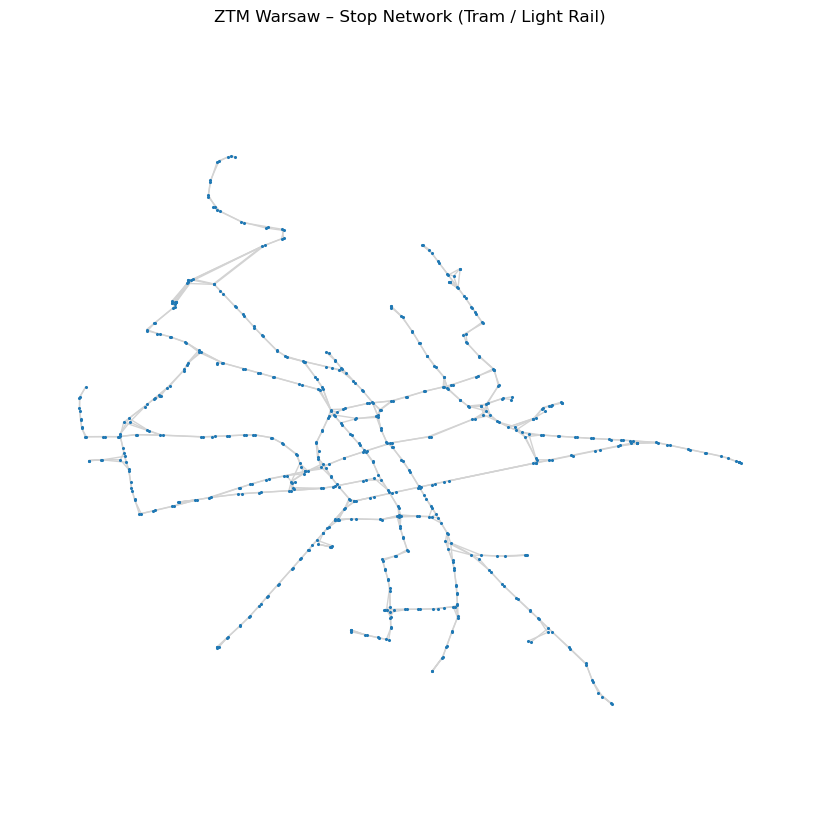

[INFO] Building graph for route_type = 1 (Metro)
[INFO] No routes found for route_type = 1
[INFO] Building graph for route_type = 2 (Rail)


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_5107/3526852830.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


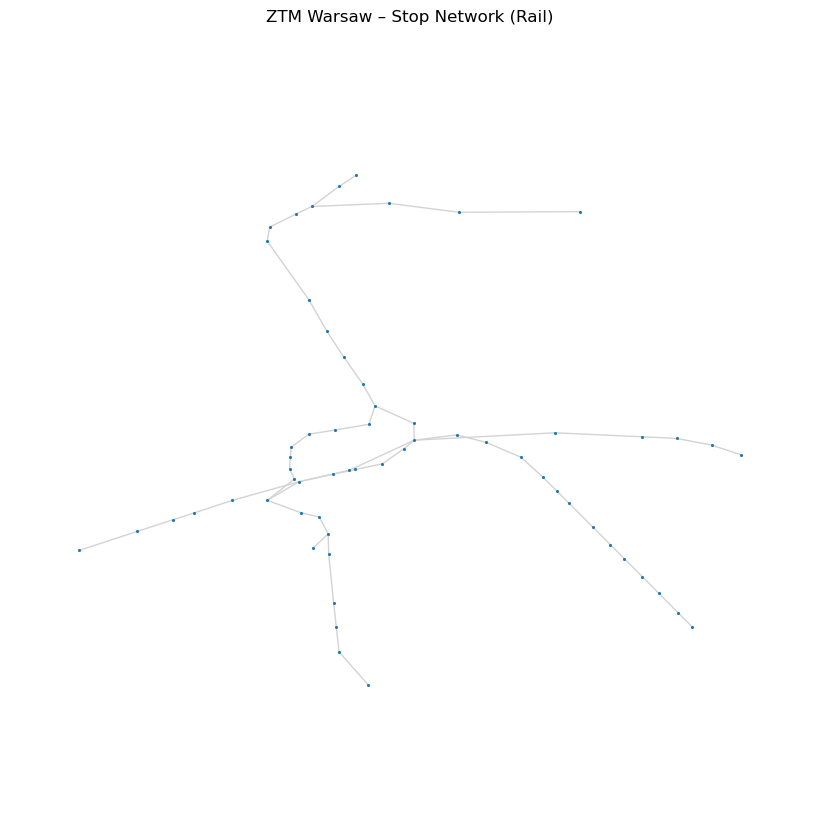

[INFO] Building graph for route_type = 3 (Bus)


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_5107/3526852830.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


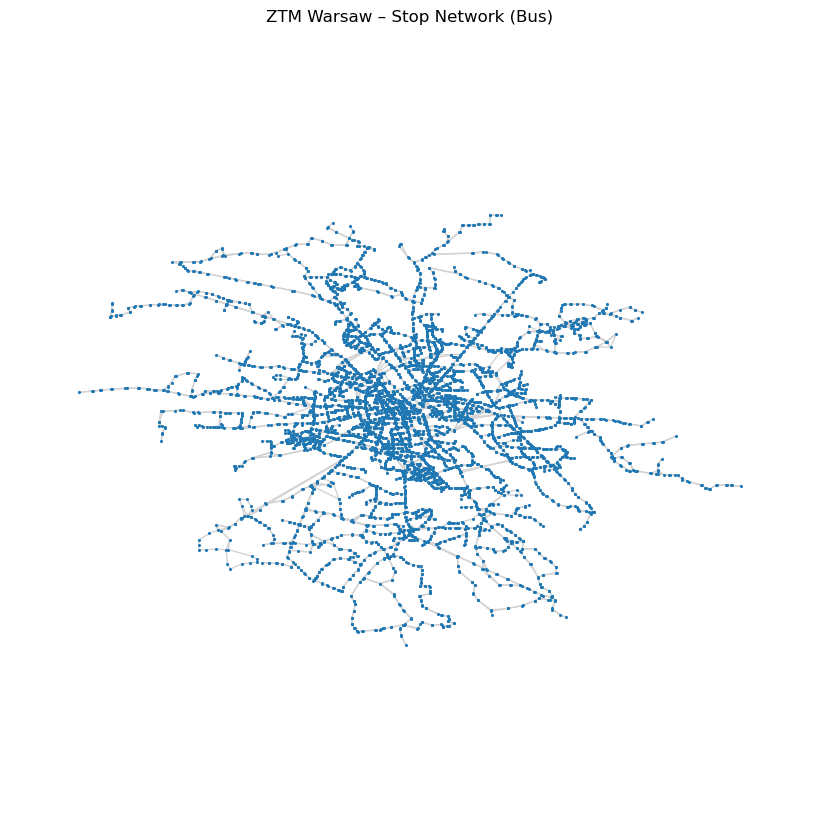

In [4]:
if __name__ == "__main__":
    main()